In [1]:
from simple_tritium_transport_model import Model, ureg, quantity_to_activity

ureg.define("T = 1 * particle")
ureg.define("n = 1 * particle")

libra_model = Model(radius=50 * ureg.cm, height= 0.6367 * ureg.m, TBR=1*ureg.T * ureg.n**-1)
print(libra_model.volume.to(ureg.L))

500.06301063515536 liter


In [2]:
libra_model.exposure_time = 12 * ureg.h
libra_model.dt = libra_model.exposure_time/10
print(f"Salt volume: {libra_model.volume.to(ureg.L):.2f~P}")
print(f"TBR: {libra_model.TBR.to(ureg.dimensionless):.4f~P}")

libra_model.number_days = 4 * ureg.days
libra_model.neutron_rate = 1e10 * ureg.neutron * ureg.s**-1
libra_model.run(t_final=25*ureg.day)

Salt volume: 500.06 l
TBR: 1.0000


C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:222: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x0 = asarray(x0).flatten()
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:237: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  retval = _minpack._hybrd(func, x0, args, 1, xtol, maxfev,
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\optimize\_minpack_py.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


The concentration of T in the sweep gas can be computed by:

$$ c_\mathrm{T,i} = \frac{Q_\mathrm{i}}{\Gamma_\mathrm{i}} $$

- $\mathrm{i} = {\mathrm{top},\ \mathrm{walls}}$
- $Q$: release rate
- $\Gamma$: sweep gas flow rate

In [3]:
NB_QUADRANTS = 4

wall_release = quantity_to_activity(libra_model.Q_wall(libra_model.concentrations))/NB_QUADRANTS
top_release = quantity_to_activity(libra_model.Q_top(libra_model.concentrations))/NB_QUADRANTS
flow_rate_wall = 100 * ureg.mL * ureg.min**-1
flow_rate_top = 100 * ureg.mL * ureg.min**-1

wall_sweep_concentration = wall_release / flow_rate_wall
top_sweep_concentration = top_release / flow_rate_top

C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_quadrature.py:353: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  y = np.asarray(y)
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\scipy\integrate\_quadrature.py:357: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  x = np.asarray(x)
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\labellines\core.py:148: UserWarning: Tried to label line Line2D(_child0), but could not find a label for it.
  warnings.warn(
C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\labellines\utils.py:27: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(value, dtype=float)


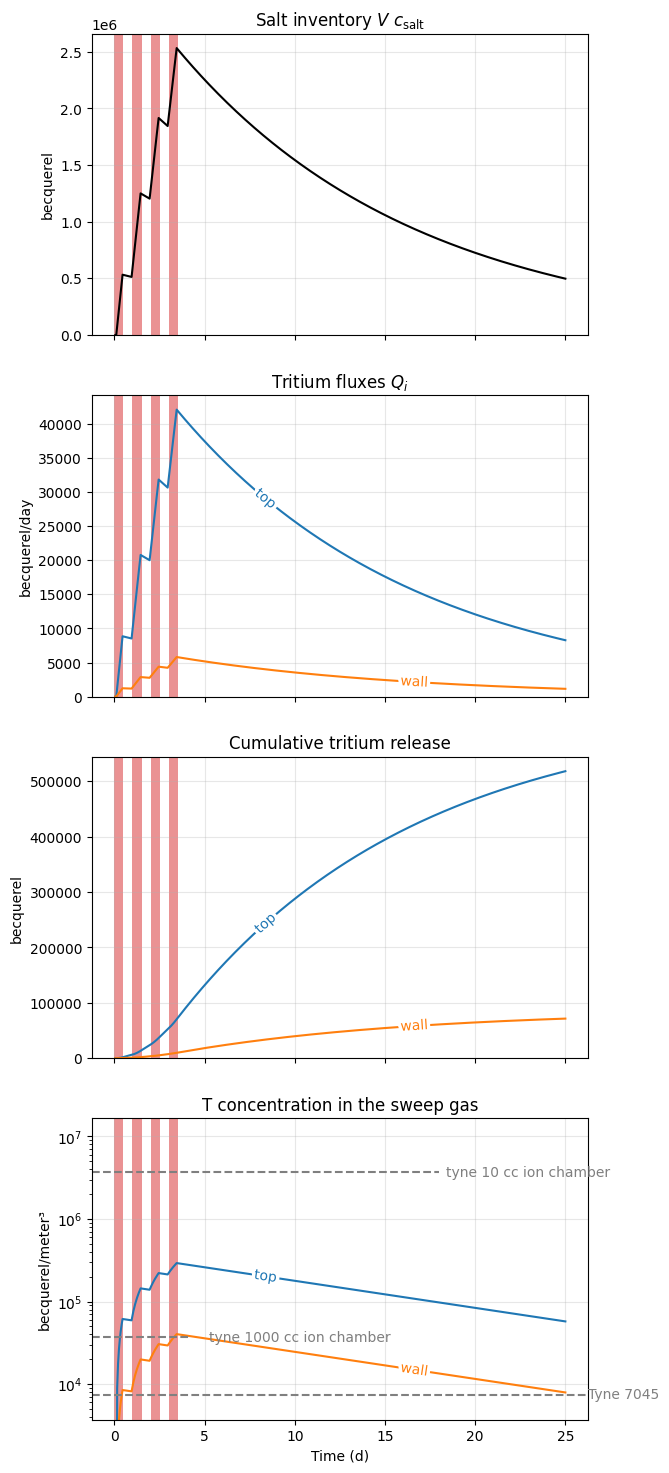

In [4]:
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from scipy.integrate import cumulative_trapezoid

time = libra_model.times.to(ureg.day)

fig, (ax_inv, ax_fluxes, ax_cumul, ax_gas_conc) = plt.subplots(4, 1, sharex=True, figsize=(6.4, 18))
plt.sca(ax_inv)
plt.title("Salt inventory $V \ c_\mathrm{salt}$")
plt.plot(
    time,
    quantity_to_activity(libra_model.concentrations * libra_model.volume).to(ureg.Bq),
    color="black",
)

plt.sca(ax_fluxes)
ax_fluxes.yaxis.set_units(ureg.Bq*ureg.day**-1)

plt.title("Tritium fluxes $Q_i$")
plt.plot(time, top_release, label="top")
plt.plot(time, wall_release, label="wall")

plt.sca(ax_cumul)
ax_cumul.yaxis.set_units(ureg.Bq)
plt.title("Cumulative tritium release")
integrated_top = (
    cumulative_trapezoid(
        top_release.to(ureg.Bq * ureg.h**-1), time.to(ureg.h), initial=0
    )
    * ureg.Bq
)
integrated_wall = (
    cumulative_trapezoid(
        wall_release.to(ureg.Bq * ureg.h**-1), time.to(ureg.h), initial=0
    )
    * ureg.Bq
)
plt.plot(time, integrated_top, label="top")
plt.plot(time, integrated_wall, label="wall")

plt.sca(ax_gas_conc)
plt.title("T concentration in the sweep gas")
ax_gas_conc.yaxis.set_units(ureg.Bq * ureg.m**-3)
plt.plot(time, top_sweep_concentration, label="top")
plt.plot(time, wall_sweep_concentration, label="wall")
tyne_1000_cc_ion_chamber = (
    1 * ureg.microcurie * ureg.m**-3
)  # http://www.tyne-engineering.com/1000%20cc%20Ion%20Chamber.html
tyne_10_cc_ion_chamber = (
    100 * ureg.microcurie * ureg.m**-3
)  # http://www.tyne-engineering.com/10%20cc%20Ion%20Chamber.html
tyne_7045_ion_chamber = (
    0.2 * ureg.microcurie * ureg.m**-3
)  # https://tyneusa.com/tritium-monitor-7045
l1 = plt.axhline(
    tyne_1000_cc_ion_chamber,
    xmax=0.2,
    linestyle="dashed",
    color="tab:grey",
    label="tyne 1000 cc ion chamber",
)
l2 = plt.axhline(
    tyne_10_cc_ion_chamber,
    xmax=0.7,
    linestyle="dashed",
    color="tab:grey",
    label="tyne 10 cc ion chamber",
)

l3 = plt.axhline(
    tyne_7045_ion_chamber, color="grey", linestyle="dashed", label="Tyne 7045"
)

for l in [l1, l2, l3]:
    plt.annotate(
        l.get_label(),
        xy=(l.get_xdata()[1] * plt.gca().get_xlim()[-1], l.get_ydata()[1]),
        va="center",
        color=l.get_color(),
    )

plt.yscale("log")
plt.ylim(bottom=tyne_1000_cc_ion_chamber/10)
plt.xlabel(f"Time ({time.units:~P})")



for ax in [ax_inv, ax_fluxes, ax_cumul, ax_gas_conc]:
    if ax.yaxis.get_scale() == "linear":
        ax.set_ylim(bottom=0)
    ax.grid(alpha=0.3)
    for day in range(libra_model.number_days.to(ureg.day).magnitude):
        ax.axvspan(0*ureg.h + day*ureg.day, libra_model.exposure_time+ day*ureg.day, facecolor='tab:red', alpha=0.5)
    lines = ax.get_lines()
    if any(l in lines for l in [l1, l2, l3]):
        lines.remove(l1)
        lines.remove(l2)
        lines.remove(l3)
    labelLines(lines, zorder=2.5)
plt.savefig("LIBRA_tritium_model.png")
plt.show()

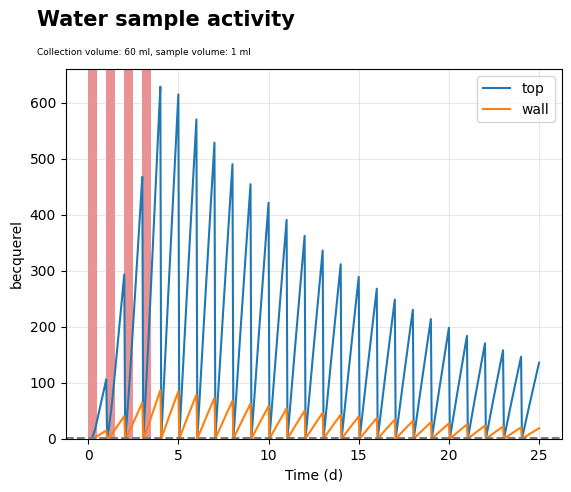

In [5]:
import numpy as np

collection_vial_volume = 60 * ureg.mL
lsc_vial_water_volume = 1 * ureg.mL

### mimick change of water everyday
top_sample_activity = integrated_top*lsc_vial_water_volume/collection_vial_volume
wall_sample_activity = integrated_wall*lsc_vial_water_volume/collection_vial_volume
top_sample_changed = np.copy(top_sample_activity)
wall_sample_changed = np.copy(wall_sample_activity)

days_water_change = [
    i + 1 for i in range(25)
]


for day in days_water_change[:-1]:
    # before each irradiation, make the sample activity drop to zero
    top_sample_changed[libra_model.times > day * ureg.day] -= top_sample_changed[
        libra_model.times > day * ureg.day
    ][0]
    wall_sample_changed[libra_model.times > day * ureg.day] -= wall_sample_changed[
        libra_model.times > day * ureg.day
    ][0]

plt.plot(time, top_sample_changed, label="top")
plt.plot(time, wall_sample_changed, label="wall")
plt.axhline(y=0.4 * ureg.Bq, color="tab:grey", linestyle="dashed")
plt.legend()
for day in range(libra_model.number_days.to(ureg.day).magnitude):
    plt.gca().axvspan(0*ureg.h + day*ureg.day, libra_model.exposure_time+ day*ureg.day, facecolor='tab:red', alpha=0.5)

plt.gcf().text(0.08, 0.97, "Water sample activity", weight="bold", fontsize=15)
subtitle = [
    f"Collection volume: {collection_vial_volume:.0f~P}, sample volume: {lsc_vial_water_volume:.0f~P}",
]

plt.gcf().text(0.08, 0.91, s="\n".join(subtitle), fontsize=6.5)

plt.xlabel(f"Time ({time.units:~P})")
plt.ylim(bottom=0)
plt.gca().grid(alpha=0.3)
plt.savefig("LIBRA_water_sample_activity.png")